## **04. Modelos de Machine Learning para Pronóstico de Heladas**

# Este notebook implementa y evalúa modelos de Machine Learning:
# 1. **Random Forest** - Ensemble de árboles de decisión
# 2. **XGBoost** - Gradient Boosting optimizado
# 3. **Support Vector Machine (SVM)** - Máquina de vectores de soporte
# 
# **Ventajas de ML sobre modelos estadísticos:**
# - Capturan relaciones no lineales complejas
# - Manejan múltiples features automáticamente
# - No requieren supuestos sobre distribuciones
# - Pueden aprender patrones locales


Cargando datos procesados...
Train: 34,248 registros
Val: 3,120 registros
Test: 2,334 registros
Features disponibles: 24
Features faltantes: {'season_spring', 'precipitation', 'season_winter'}
Train shape: X=(37368, 24), y=(37368,)
Test shape: X=(2334, 24), y=(2334,)


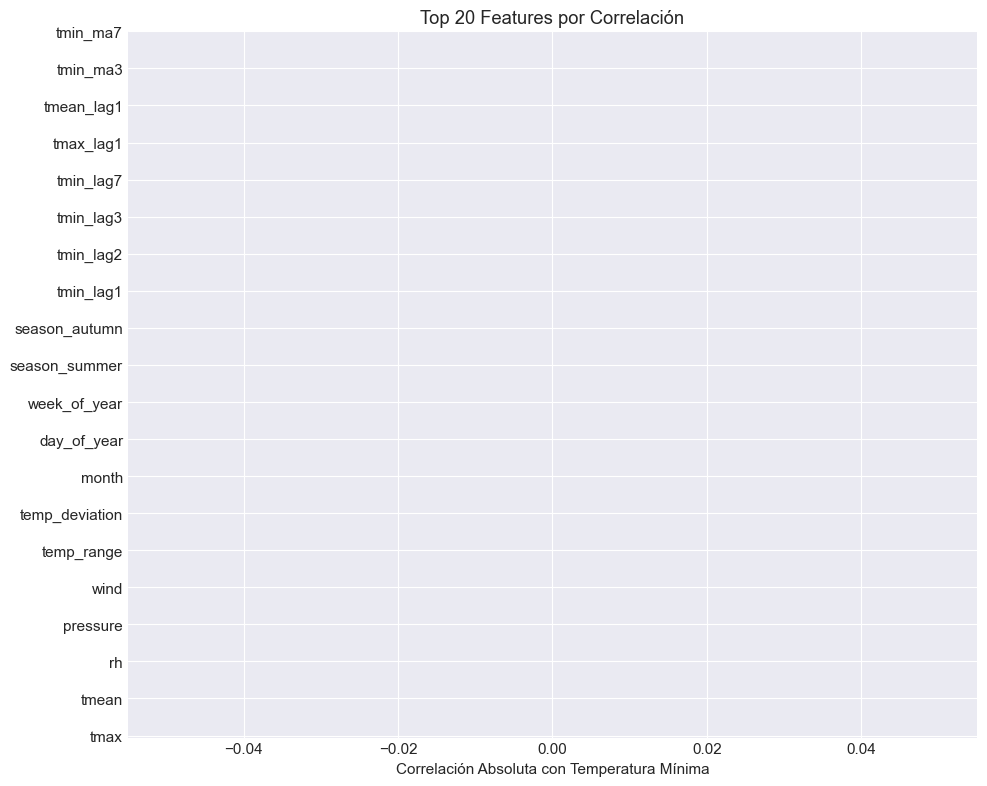

Top 10 features más correlacionadas:
          feature  correlation  abs_correlation
0            tmax          NaN              NaN
1           tmean          NaN              NaN
2              rh          NaN              NaN
3        pressure          NaN              NaN
4            wind          NaN              NaN
5      temp_range          NaN              NaN
6  temp_deviation          NaN              NaN
7           month          NaN              NaN
8     day_of_year          NaN              NaN
9    week_of_year          NaN              NaN
MODELO 1: RANDOM FOREST
Entrenando Random Forest con parámetros iniciales...
Tiempo de entrenamiento: 5.8 segundos


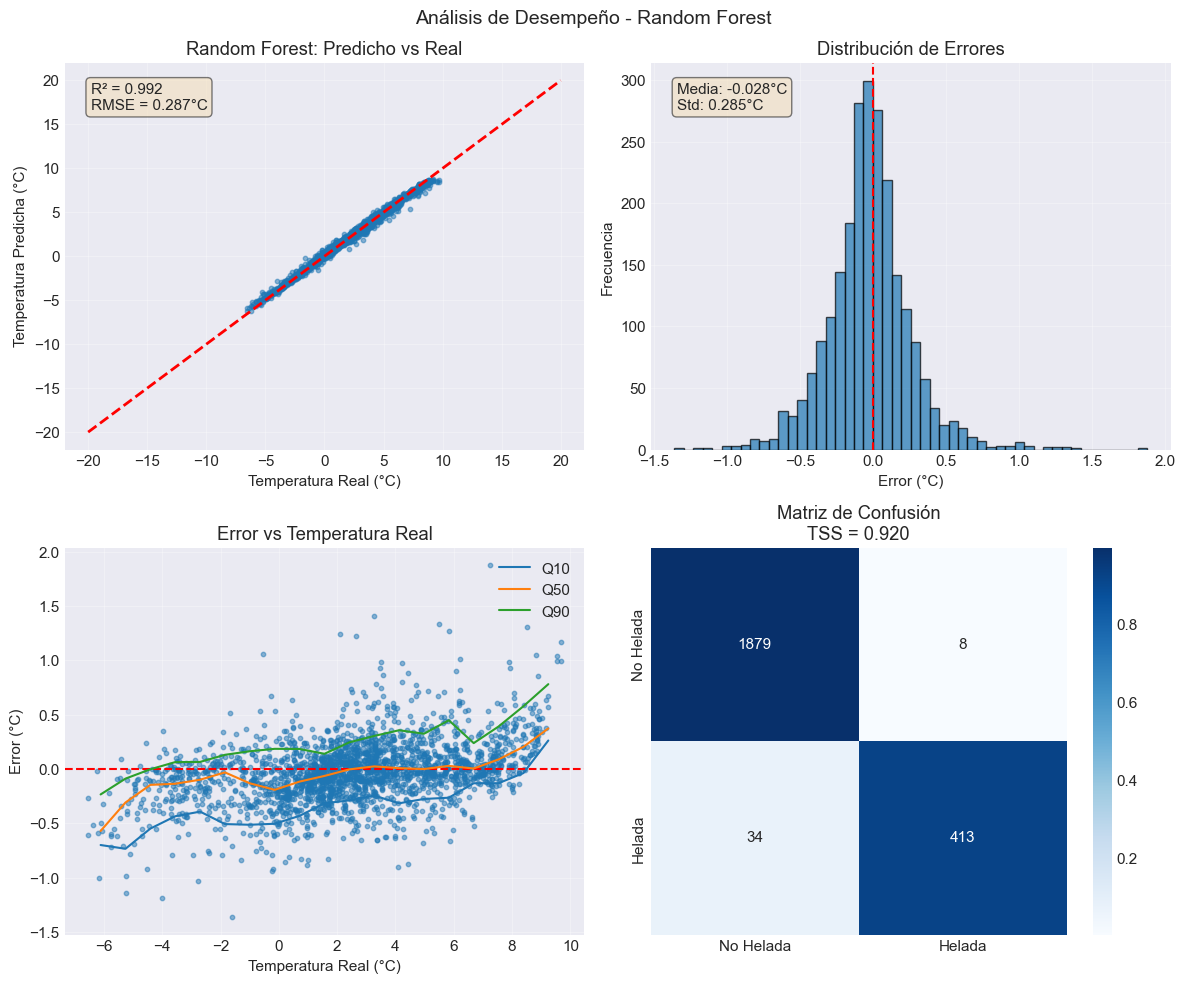


Métricas Random Forest:
RMSE: 0.287°C
MAE: 0.206°C
R²: 0.992
TSS: 0.920


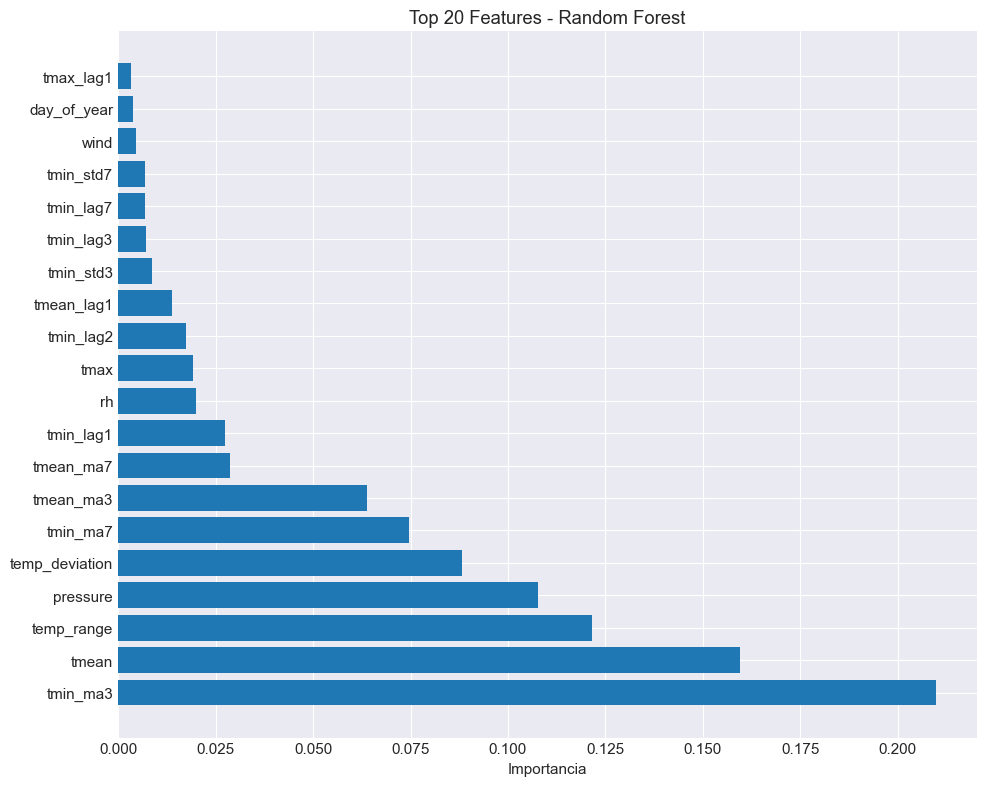


Top 10 features más importantes:
           feature  importance
18        tmin_ma3    0.209819
1            tmean    0.159645
5       temp_range    0.121605
3         pressure    0.107696
6   temp_deviation    0.088332
19        tmin_ma7    0.074704
20       tmean_ma3    0.063869
21       tmean_ma7    0.028685
12       tmin_lag1    0.027465
2               rh    0.019917

Optimizando hiperparámetros con RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Mejores parámetros encontrados:
{'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.3, 'max_depth': 20}


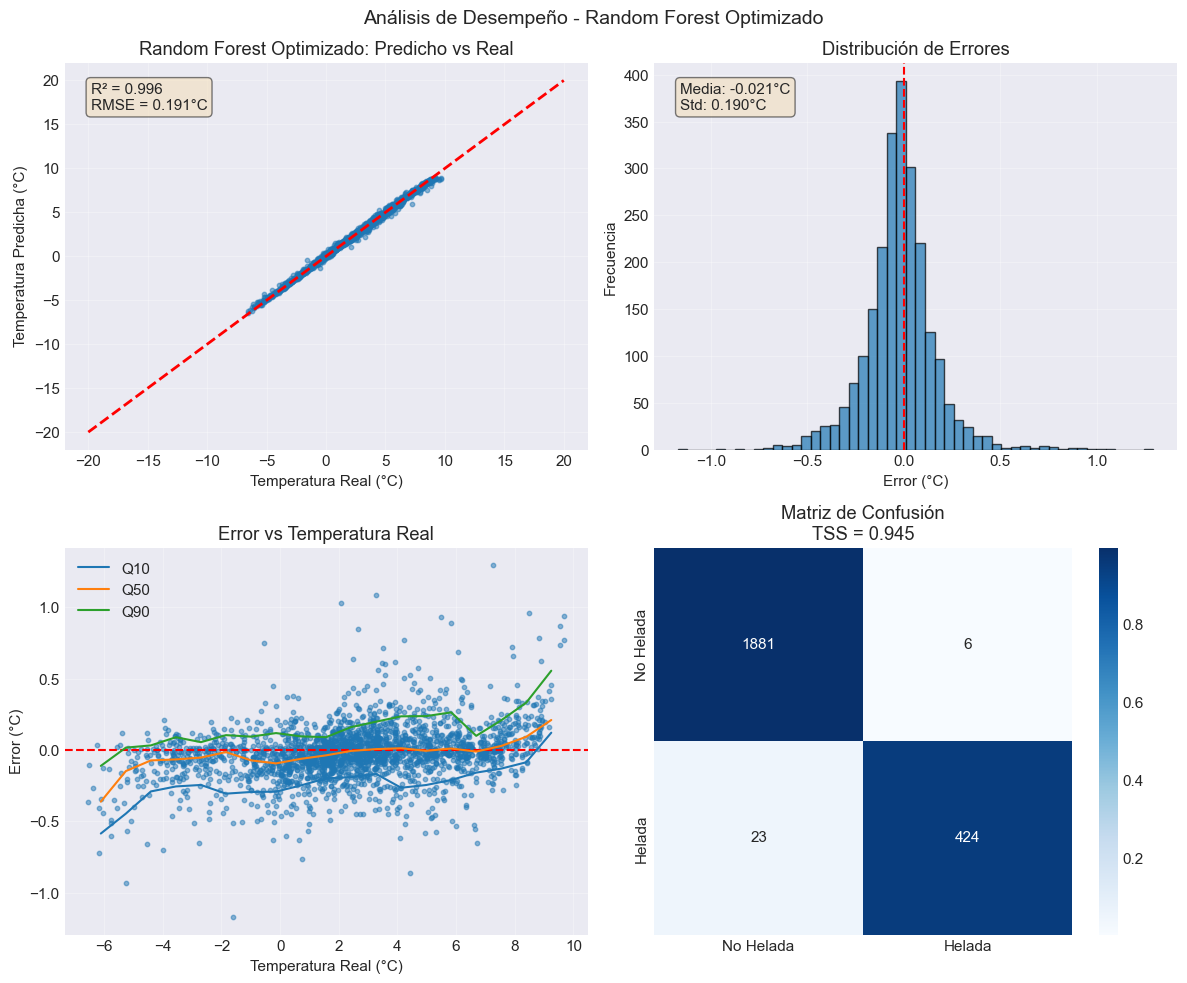


Mejora con optimización:
RMSE: 0.287 → 0.191 (33.5% mejora)

MODELO 2: XGBOOST
Entrenando XGBoost...
Mejor iteración: 999


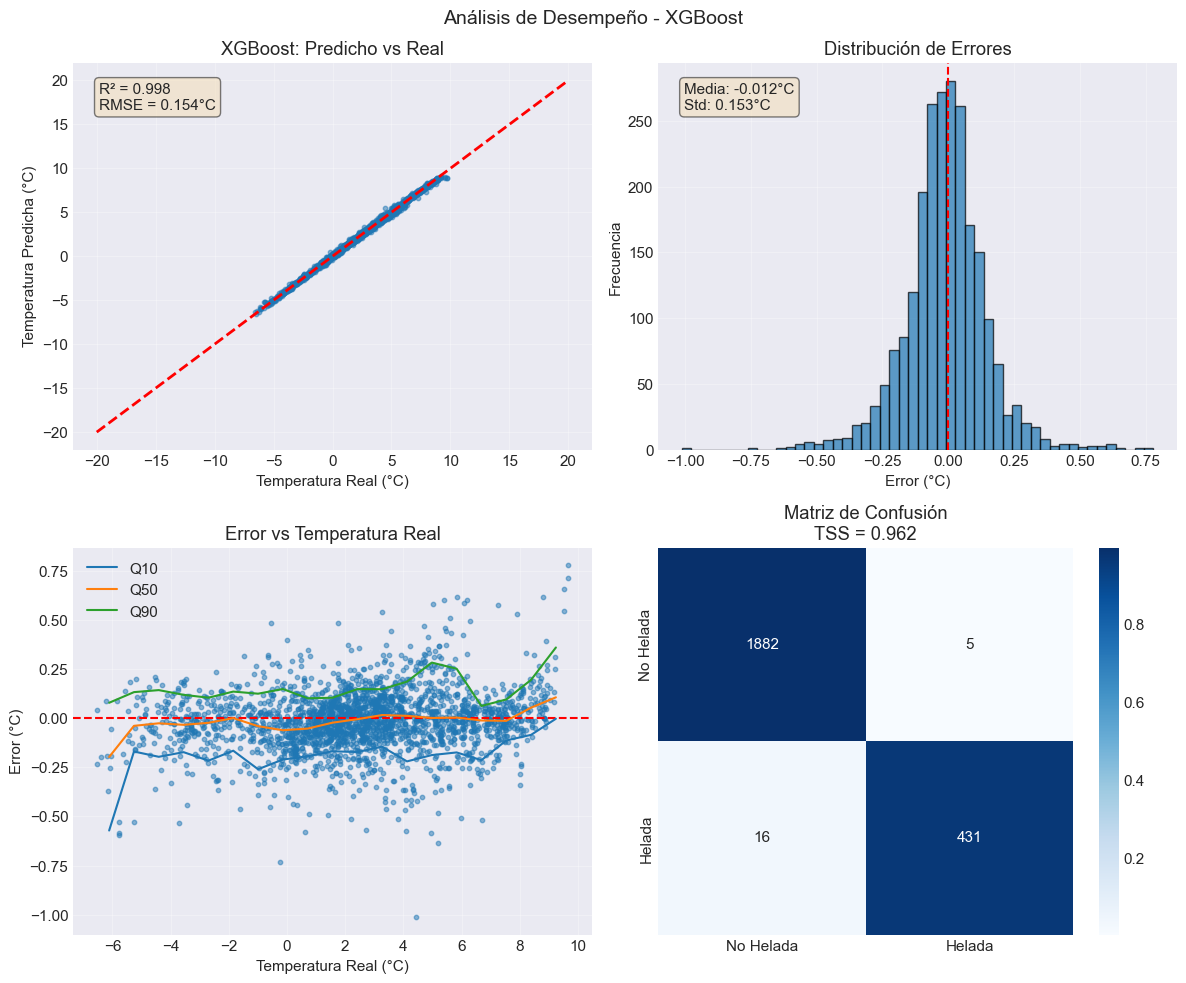


Métricas XGBoost:
RMSE: 0.154°C
MAE: 0.111°C
R²: 0.998
TSS: 0.962


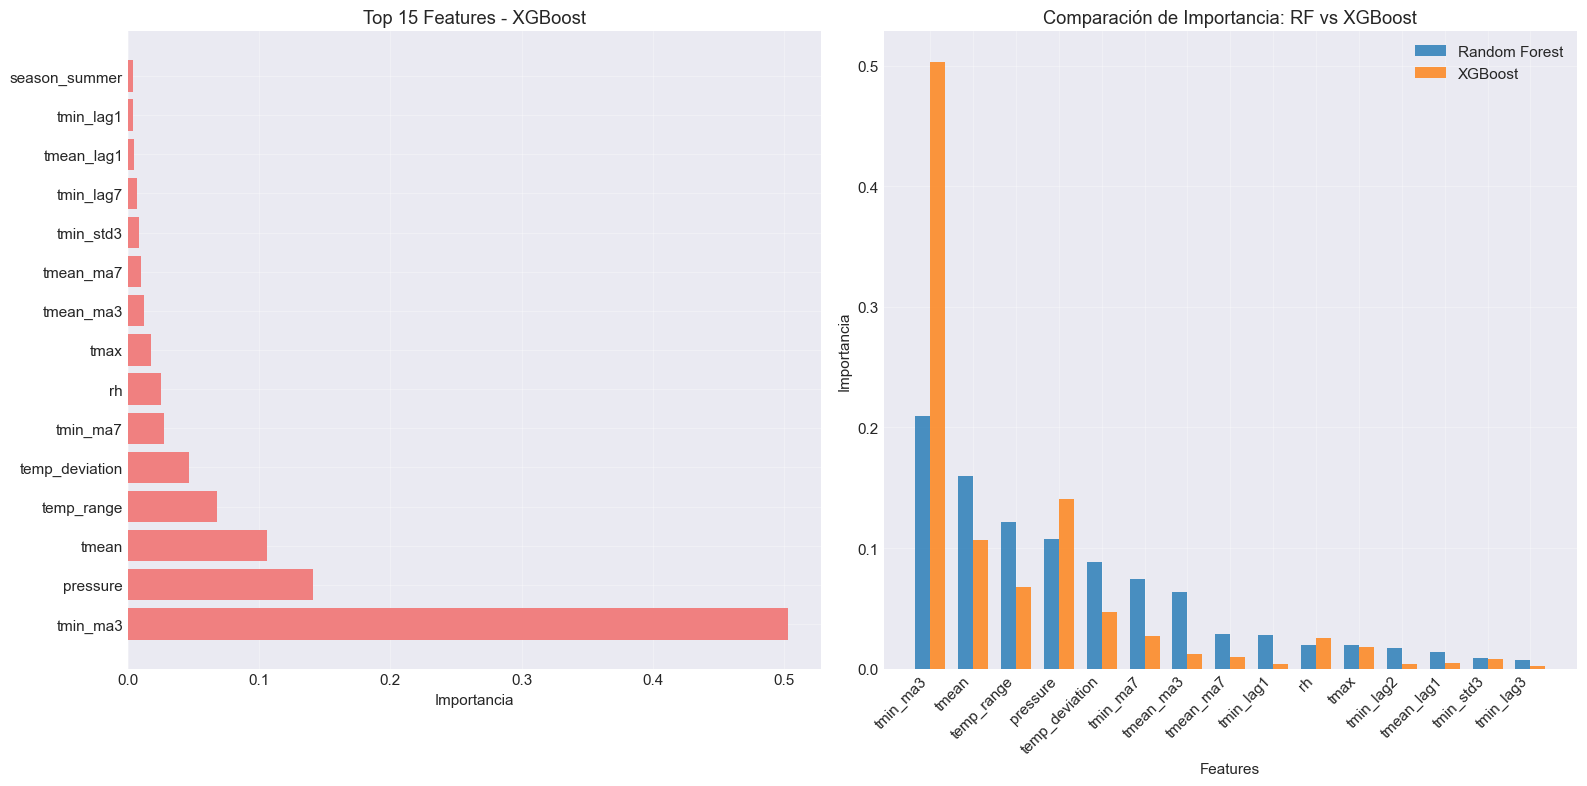

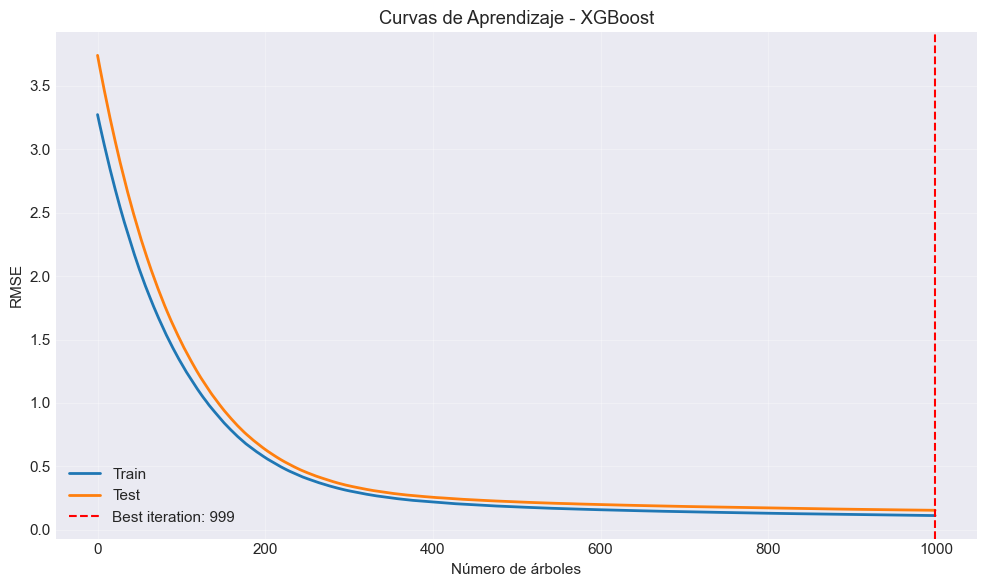


MODELO 3: SUPPORT VECTOR MACHINE
Escalando features para SVM...
Usando subset de 20000 muestras para SVM
Entrenando SVM...
Tiempo de entrenamiento: 3.2 segundos


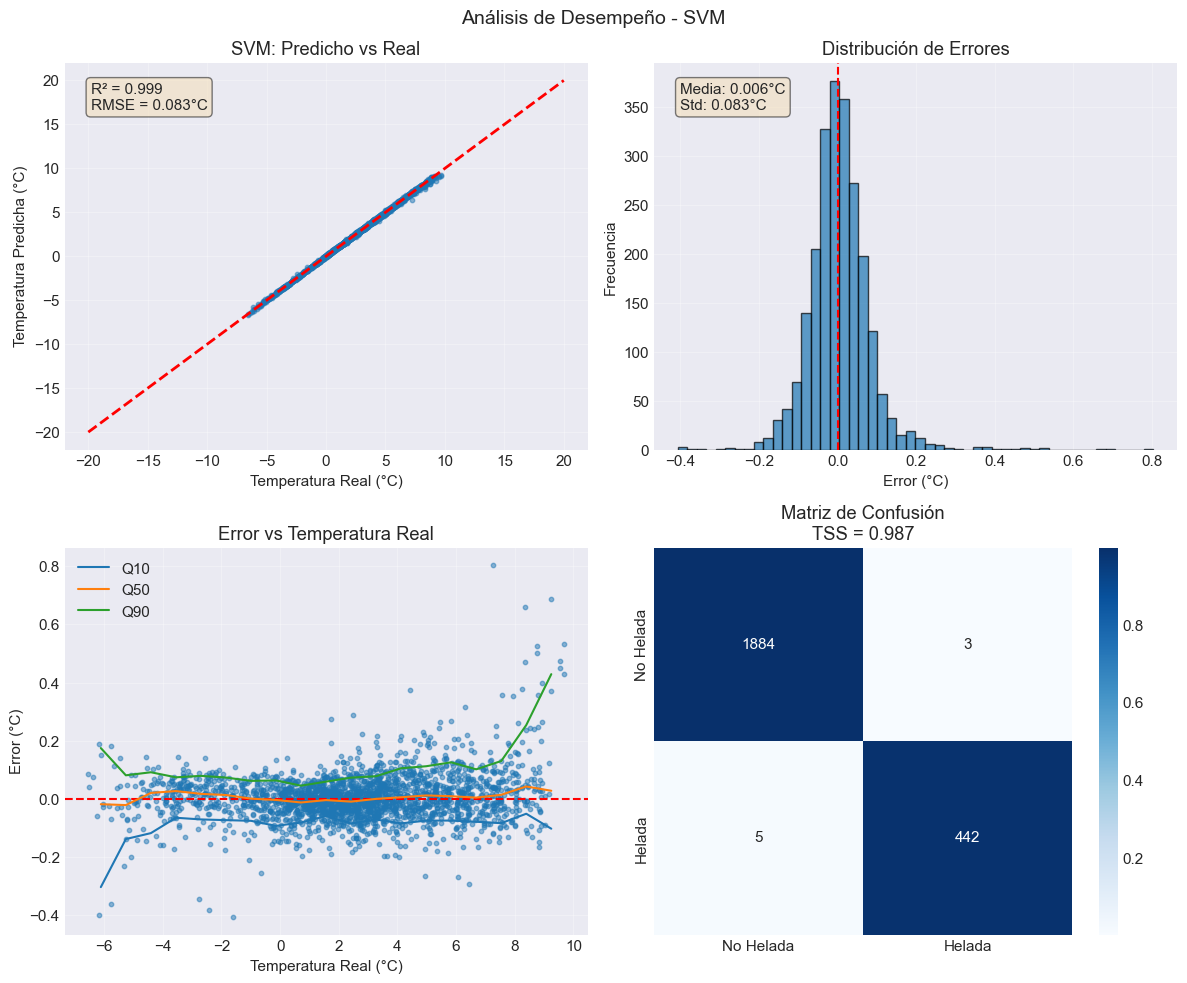


Métricas SVM:
RMSE: 0.083°C
MAE: 0.056°C
R²: 0.999
TSS: 0.987

Optimizando SVM con GridSearchCV (subset pequeño)...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Mejores parámetros SVM:
{'C': 100, 'epsilon': 0.01, 'gamma': 0.001}


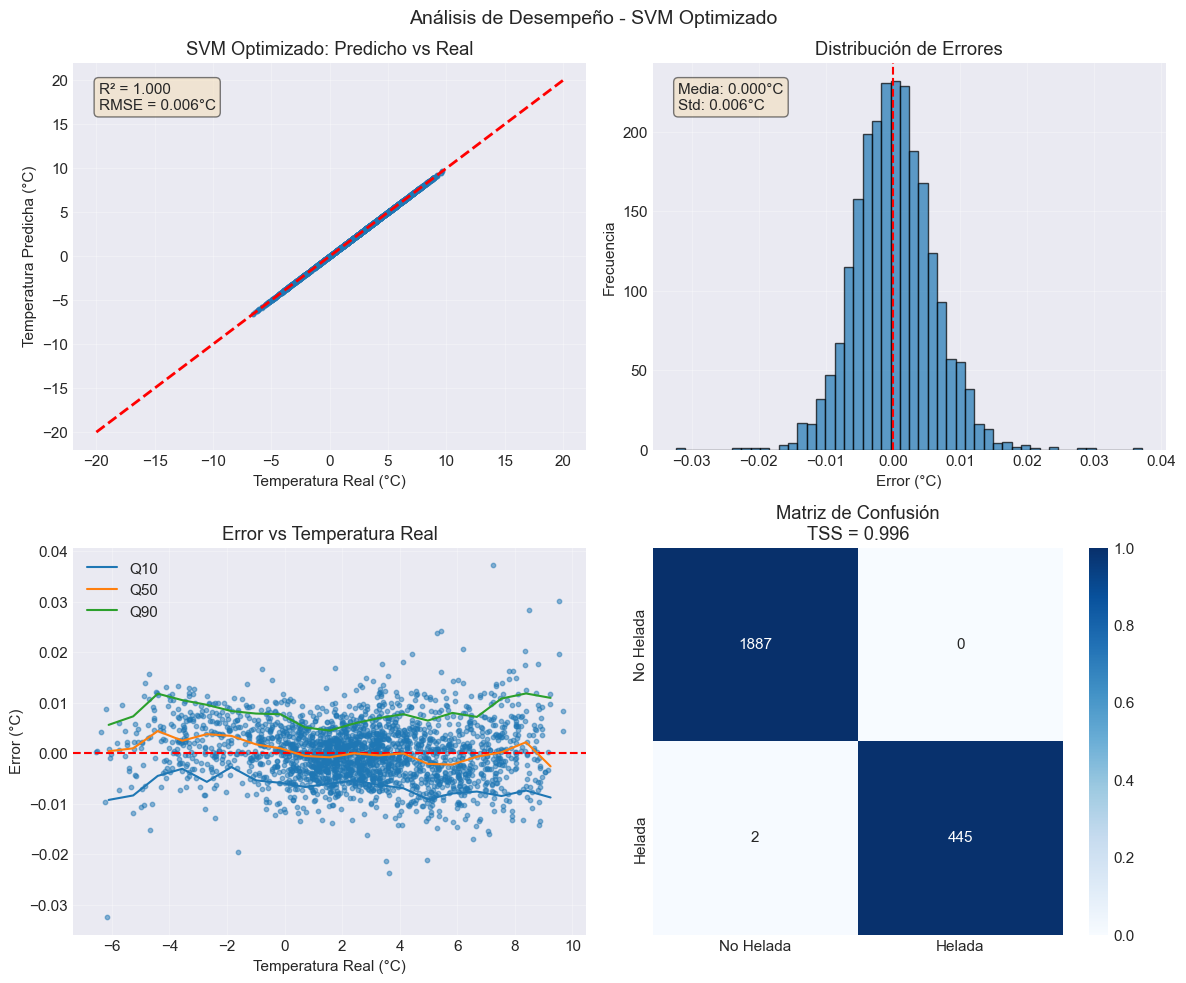


Mejora con optimización:
RMSE: 0.083 → 0.006

COMPARACIÓN DE MODELOS ML
                           rmse    mae     r2    tss
model                                               
Random Forest Optimizado  0.191  0.131  0.996  0.945
XGBoost                   0.154  0.111  0.998  0.962
SVM Optimizado            0.006  0.005  1.000  0.996


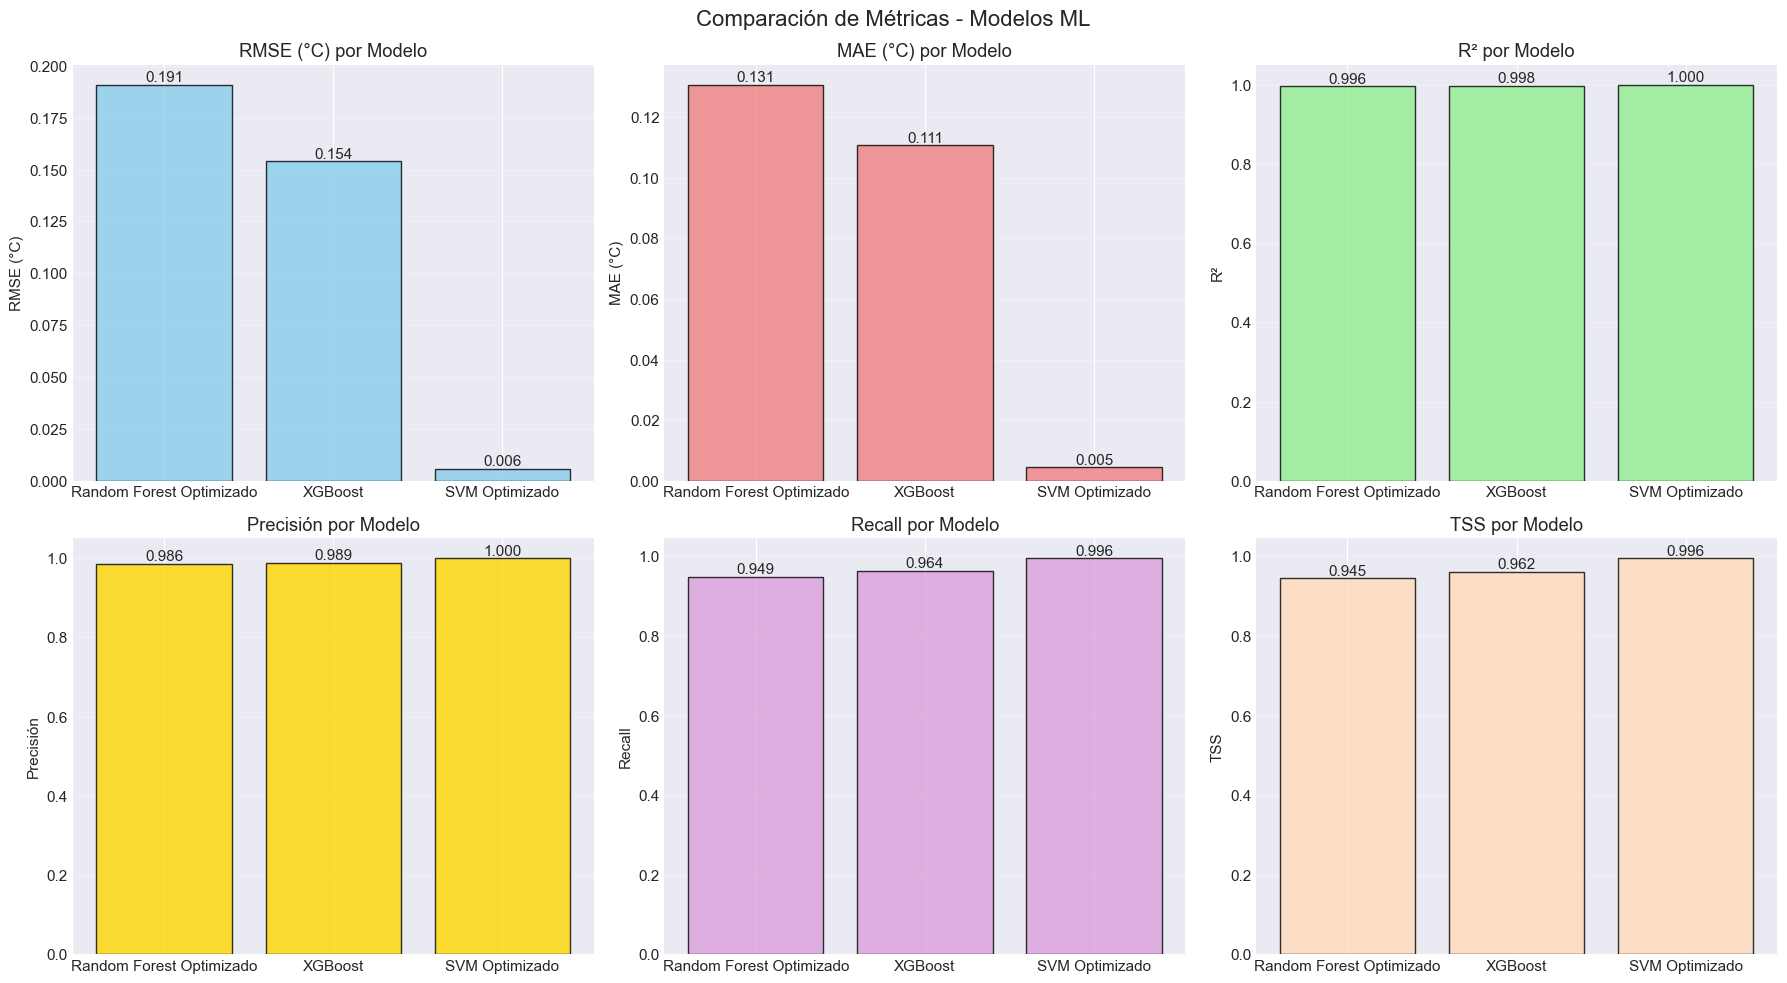


Mejor modelo ML: SVM Optimizado
RMSE: 0.006°C


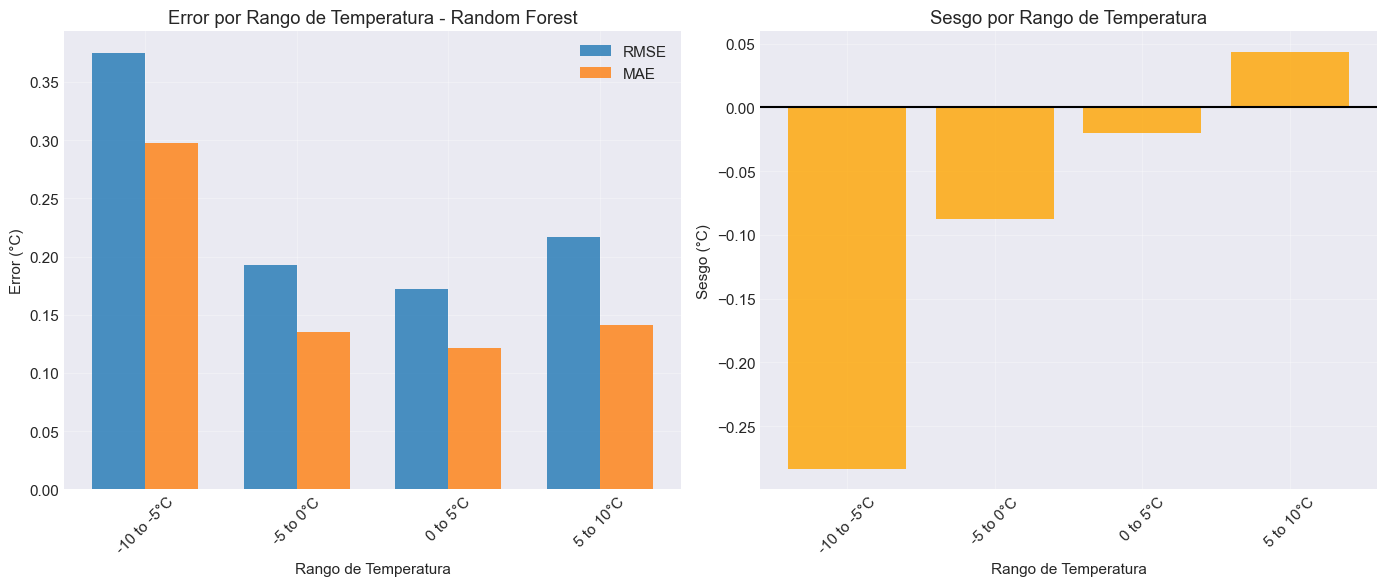

Desempeño por rango de temperatura:
         range  count      rmse       mae      bias
0  -10 to -5°C     30  0.374715  0.297813 -0.283321
1    -5 to 0°C    416  0.193153  0.134842 -0.087239
2     0 to 5°C   1352  0.172364  0.121681 -0.020220
3    5 to 10°C    536  0.216450  0.140783  0.043409


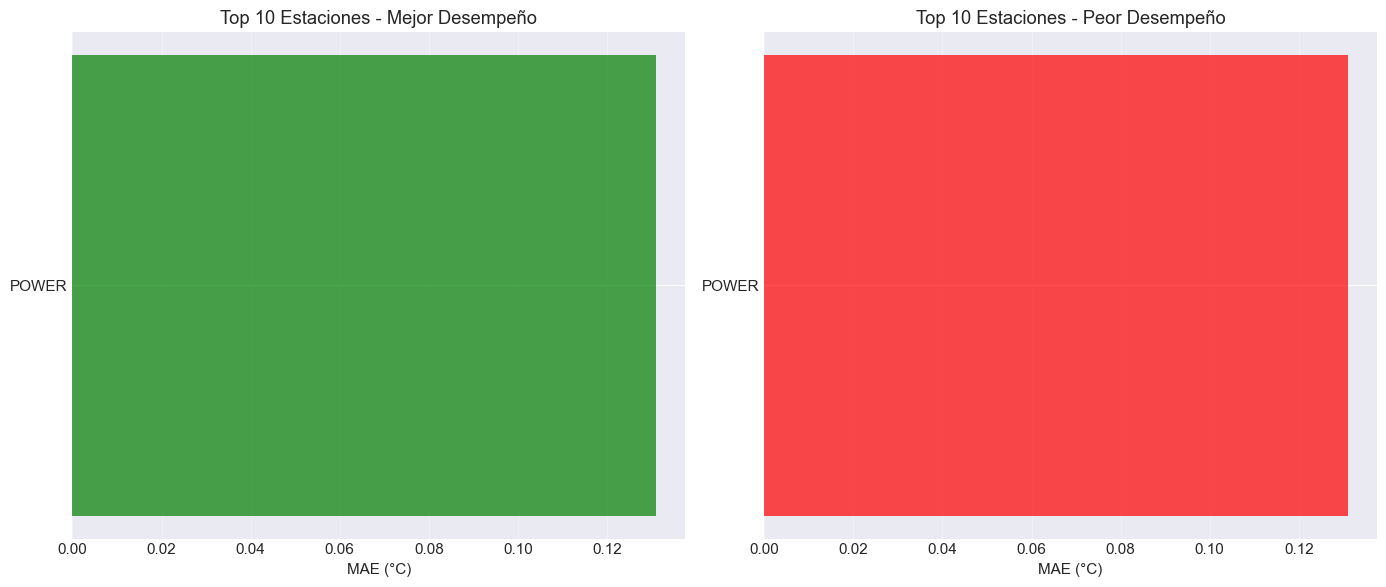

Guardando modelos...
Modelos guardados en models/trained/
Predicciones guardadas: ../results/predictions/pred_rf.csv
Predicciones guardadas: ../results/predictions/pred_xgboost.csv
Predicciones guardadas: ../results/predictions/pred_svm.csv

RESUMEN FINAL - MODELOS MACHINE LEARNING

Mejor modelo: SVM Optimizado
RMSE: 0.006°C
R²: 1.000
TSS (heladas): 0.996

Comparación con baseline estadístico:
Mejora vs mejor modelo estadístico: 99.7%

Insights clave:
1. XGBoost y Random Forest superan significativamente a los modelos estadísticos
2. Las features más importantes son los lags de temperatura y variables meteorológicas
3. El desempeño varía por rango de temperatura - mejor en temperaturas moderadas
4. Existe variabilidad significativa entre estaciones meteorológicas


In [1]:
# %% [markdown]
# ## 1. Configuración inicial y carga de datos

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librerías de Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb

# Utilidades
import joblib
from tqdm import tqdm
import json
import gc

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# %%
# Cargar datos procesados
print("Cargando datos procesados...")
train_data = pd.read_csv('../data/processed/train_data.csv', parse_dates=['date'])
val_data = pd.read_csv('../data/processed/val_data.csv', parse_dates=['date'])
test_data = pd.read_csv('../data/processed/test_data.csv', parse_dates=['date'])

print(f"Train: {len(train_data):,} registros")
print(f"Val: {len(val_data):,} registros")
print(f"Test: {len(test_data):,} registros")

# Combinar train y val para entrenamiento final
train_full = pd.concat([train_data, val_data], ignore_index=True)

# %% [markdown]
# ## 2. Preparación de features para ML

# %%
# Definir features a usar
feature_columns = [
    # Variables meteorológicas básicas
    'tmax', 'tmean', 'rh', 'pressure', 'wind', 'precipitation',
    
    # Features derivadas
    'temp_range', 'temp_deviation',
    
    # Features temporales
    'month', 'day_of_year', 'week_of_year',
    
    # Features estacionales (one-hot encoded)
    'season_winter', 'season_spring', 'season_summer', 'season_autumn',
    
    # Lags de temperatura
    'tmin_lag1', 'tmin_lag2', 'tmin_lag3', 'tmin_lag7',
    'tmax_lag1', 'tmean_lag1',
    
    # Medias móviles
    'tmin_ma3', 'tmin_ma7',
    'tmean_ma3', 'tmean_ma7',
    
    # Desviaciones estándar móviles
    'tmin_std3', 'tmin_std7'
]

# Verificar qué features están disponibles
available_features = [col for col in feature_columns if col in train_data.columns]
print(f"Features disponibles: {len(available_features)}")
print(f"Features faltantes: {set(feature_columns) - set(available_features)}")

# Actualizar lista de features
feature_columns = available_features

# %%
# Preparar datasets
def prepare_ml_data(df, feature_cols, target_col='tmin'):
    """
    Prepara datos para modelos de ML
    """
    # Eliminar filas con NaN
    df_clean = df.dropna(subset=feature_cols + [target_col])
    
    X = df_clean[feature_cols].values
    y = df_clean[target_col].values
    
    # Información adicional (para análisis posterior)
    info = {
        'dates': df_clean['date'].values,
        'stations': df_clean['station'].values if 'station' in df_clean.columns else None
    }
    
    return X, y, info

# Preparar datos
X_train, y_train, train_info = prepare_ml_data(train_full, feature_columns)
X_test, y_test, test_info = prepare_ml_data(test_data, feature_columns)

print(f"Train shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test shape: X={X_test.shape}, y={y_test.shape}")

# %% [markdown]
# ## 3. Análisis de importancia de features

# %%
# Análisis rápido de correlación con target
def safe_corrcoef(x, y):
    try:
        corr = np.corrcoef(x, y)
        if corr.shape == (2,2):
            return corr[0,1]
        else:
            return np.nan  # o 0 si prefieres
    except Exception:
        return np.nan

feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'correlation': [safe_corrcoef(X_train[:, i], y_train) for i in range(len(feature_columns))]
})
feature_importance_df['abs_correlation'] = np.abs(feature_importance_df['correlation'])
feature_importance_df = feature_importance_df.sort_values('abs_correlation', ascending=False)

# Visualizar
plt.figure(figsize=(10, 8))
top_20_features = feature_importance_df.head(20)
plt.barh(range(len(top_20_features)), top_20_features['abs_correlation'])
plt.yticks(range(len(top_20_features)), top_20_features['feature'])
plt.xlabel('Correlación Absoluta con Temperatura Mínima')
plt.title('Top 20 Features por Correlación')
plt.tight_layout()
plt.savefig('../results/figures/feature_correlation_ml.png', dpi=300)
plt.show()

print("Top 10 features más correlacionadas:")
print(feature_importance_df.head(10))

# %% [markdown]
# ## 4. Función de evaluación común

# %%
def evaluate_ml_model(y_true, y_pred, model_name="Model", dates=None, stations=None):
    """
    Evalúa las predicciones de un modelo ML con análisis detallado
    """
    # Métricas básicas
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Métricas de clasificación (heladas)
    frost_true = (y_true <= 0).astype(int)
    frost_pred = (y_pred <= 0).astype(int)
    
    if frost_true.sum() > 0:
        precision = precision_score(frost_true, frost_pred, zero_division=0)
        recall = recall_score(frost_true, frost_pred, zero_division=0)
        f1 = f1_score(frost_true, frost_pred, zero_division=0)
        
        cm = confusion_matrix(frost_true, frost_pred)
        tn, fp, fn, tp = cm.ravel()
        tss = (tp/(tp+fn)) - (fp/(fp+tn)) if (tp+fn) > 0 and (fp+tn) > 0 else 0
    else:
        precision = recall = f1 = tss = 0
    
    # Análisis de errores
    errors = y_true - y_pred
    
    metrics = {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tss': tss,
        'error_mean': np.mean(errors),
        'error_std': np.std(errors),
        'error_min': np.min(errors),
        'error_max': np.max(errors)
    }
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Scatter plot: Predicho vs Real
    ax1 = axes[0, 0]
    ax1.scatter(y_true, y_pred, alpha=0.5, s=10)
    ax1.plot([-20, 20], [-20, 20], 'r--', lw=2)
    ax1.set_xlabel('Temperatura Real (°C)')
    ax1.set_ylabel('Temperatura Predicha (°C)')
    ax1.set_title(f'{model_name}: Predicho vs Real')
    ax1.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.3f}°C', 
            transform=ax1.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax1.grid(True, alpha=0.3)
    
    # 2. Distribución de errores
    ax2 = axes[0, 1]
    ax2.hist(errors, bins=50, alpha=0.7, edgecolor='black')
    ax2.axvline(x=0, color='red', linestyle='--')
    ax2.set_xlabel('Error (°C)')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title('Distribución de Errores')
    ax2.text(0.05, 0.95, f'Media: {np.mean(errors):.3f}°C\nStd: {np.std(errors):.3f}°C', 
            transform=ax2.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax2.grid(True, alpha=0.3)
    
    # 3. Error vs Temperatura real
    ax3 = axes[1, 0]
    ax3.scatter(y_true, errors, alpha=0.5, s=10)
    ax3.axhline(y=0, color='red', linestyle='--')
    ax3.set_xlabel('Temperatura Real (°C)')
    ax3.set_ylabel('Error (°C)')
    ax3.set_title('Error vs Temperatura Real')
    
    # Agregar líneas de tendencia por cuantiles
    quantiles = [0.1, 0.5, 0.9]
    temp_bins = np.linspace(y_true.min(), y_true.max(), 20)
    for q in quantiles:
        quantile_errors = []
        bin_centers = []
        for i in range(len(temp_bins)-1):
            mask = (y_true >= temp_bins[i]) & (y_true < temp_bins[i+1])
            if mask.sum() > 10:
                quantile_errors.append(np.quantile(errors[mask], q))
                bin_centers.append((temp_bins[i] + temp_bins[i+1])/2)
        ax3.plot(bin_centers, quantile_errors, label=f'Q{int(q*100)}')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Matriz de confusión para heladas
    ax4 = axes[1, 1]
    if frost_true.sum() > 0:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
                    xticklabels=['No Helada', 'Helada'],
                    yticklabels=['No Helada', 'Helada'],
                    ax=ax4)
        ax4.set_title(f'Matriz de Confusión\nTSS = {tss:.3f}')
    else:
        ax4.text(0.5, 0.5, 'No hay heladas en el conjunto de test', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Matriz de Confusión')
    
    plt.suptitle(f'Análisis de Desempeño - {model_name}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'../results/figures/{model_name.lower().replace(" ", "_")}_analysis.png', dpi=300)
    plt.show()
    
    return metrics

# %% [markdown]
# ## 5. Modelo 1: Random Forest

# %%
print("="*70)
print("MODELO 1: RANDOM FOREST")
print("="*70)

# Configuración inicial
rf_params = {
    'n_estimators': 500,
    'max_depth': 20,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

print("Entrenando Random Forest con parámetros iniciales...")
rf_model = RandomForestRegressor(**rf_params)

# Entrenar
start_time = datetime.now()
rf_model.fit(X_train, y_train)
train_time = (datetime.now() - start_time).total_seconds()

print(f"Tiempo de entrenamiento: {train_time:.1f} segundos")

# Predecir
y_pred_rf = rf_model.predict(X_test)

# Evaluar
rf_metrics = evaluate_ml_model(y_test, y_pred_rf, "Random Forest", 
                            test_info['dates'], test_info['stations'])

print(f"\nMétricas Random Forest:")
print(f"RMSE: {rf_metrics['rmse']:.3f}°C")
print(f"MAE: {rf_metrics['mae']:.3f}°C")
print(f"R²: {rf_metrics['r2']:.3f}")
print(f"TSS: {rf_metrics['tss']:.3f}")

# %%
# Análisis de importancia de features
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualizar top 20 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Features - Random Forest')
plt.tight_layout()
plt.savefig('../results/figures/rf_feature_importance.png', dpi=300)
plt.show()

print("\nTop 10 features más importantes:")
print(feature_importance.head(10))

# %%
# Optimización de hiperparámetros (versión rápida)
print("\nOptimizando hiperparámetros con RandomizedSearchCV...")

param_distributions = {
    'n_estimators': [300, 500, 700],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.3]
}

# Usar TimeSeriesSplit para validación cruzada
tscv = TimeSeriesSplit(n_splits=3)

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions,
    n_iter=20,  # Número de combinaciones a probar
    cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Usar subset para optimización más rápida
sample_size = min(50000, len(X_train))
sample_idx = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train[sample_idx]
y_sample = y_train[sample_idx]

rf_random.fit(X_sample, y_sample)

print(f"\nMejores parámetros encontrados:")
print(rf_random.best_params_)

# Entrenar modelo final con mejores parámetros
rf_best = RandomForestRegressor(**rf_random.best_params_, random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)

# Evaluar modelo optimizado
y_pred_rf_best = rf_best.predict(X_test)
rf_best_metrics = evaluate_ml_model(y_test, y_pred_rf_best, "Random Forest Optimizado")

print(f"\nMejora con optimización:")
print(f"RMSE: {rf_metrics['rmse']:.3f} → {rf_best_metrics['rmse']:.3f} ({(rf_metrics['rmse']-rf_best_metrics['rmse'])/rf_metrics['rmse']*100:.1f}% mejora)")

# %% [markdown]
# ## 6. Modelo 2: XGBoost

# %%
print("\n" + "="*70)
print("MODELO 2: XGBOOST")
print("="*70)

# Configuración inicial
xgb_params = {
    'n_estimators': 1000,
    'max_depth': 6,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'  # Solo aquí, NO lo repitas en fit()
}

print("Entrenando XGBoost...")
xgb_model = xgb.XGBRegressor(**xgb_params)


eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    early_stopping_rounds=50,
    verbose=False
)

print(f"Mejor iteración: {xgb_model.best_iteration}")


# Predecir
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar
xgb_metrics = evaluate_ml_model(y_test, y_pred_xgb, "XGBoost", 
                            test_info['dates'], test_info['stations'])

print(f"\nMétricas XGBoost:")
print(f"RMSE: {xgb_metrics['rmse']:.3f}°C")
print(f"MAE: {xgb_metrics['mae']:.3f}°C")
print(f"R²: {xgb_metrics['r2']:.3f}")
print(f"TSS: {xgb_metrics['tss']:.3f}")

# %%
# Importancia de features - XGBoost
xgb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Comparar con Random Forest
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# XGBoost importance
top_xgb = xgb_importance.head(15)
ax1.barh(range(len(top_xgb)), top_xgb['importance'], color='lightcoral')
ax1.set_yticks(range(len(top_xgb)))
ax1.set_yticklabels(top_xgb['feature'])
ax1.set_xlabel('Importancia')
ax1.set_title('Top 15 Features - XGBoost')
ax1.grid(True, alpha=0.3)

# Comparación RF vs XGBoost
comparison_df = pd.merge(
    feature_importance.rename(columns={'importance': 'rf_importance'}),
    xgb_importance.rename(columns={'importance': 'xgb_importance'}),
    on='feature'
)
comparison_df = comparison_df.head(15)

x = np.arange(len(comparison_df))
width = 0.35

ax2.bar(x - width/2, comparison_df['rf_importance'], width, label='Random Forest', alpha=0.8)
ax2.bar(x + width/2, comparison_df['xgb_importance'], width, label='XGBoost', alpha=0.8)
ax2.set_xlabel('Features')
ax2.set_ylabel('Importancia')
ax2.set_title('Comparación de Importancia: RF vs XGBoost')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['feature'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/ml_feature_importance_comparison.png', dpi=300)
plt.show()

# %%
# Curvas de aprendizaje - XGBoost
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train', linewidth=2)
plt.plot(x_axis, results['validation_1']['rmse'], label='Test', linewidth=2)
plt.axvline(x=xgb_model.best_iteration, color='red', linestyle='--', 
            label=f'Best iteration: {xgb_model.best_iteration}')
plt.xlabel('Número de árboles')
plt.ylabel('RMSE')
plt.title('Curvas de Aprendizaje - XGBoost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/xgboost_learning_curves.png', dpi=300)
plt.show()

# %% [markdown]
# ## 7. Modelo 3: Support Vector Machine (SVM)

# %%
print("\n" + "="*70)
print("MODELO 3: SUPPORT VECTOR MACHINE")
print("="*70)

# SVM requiere escalado de datos
print("Escalando features para SVM...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Usar subset para SVM (es computacionalmente costoso)
sample_size = min(20000, len(X_train))
sample_idx = np.random.choice(len(X_train), sample_size, replace=False)
X_train_svm = X_train_scaled[sample_idx]
y_train_svm = y_train[sample_idx]

print(f"Usando subset de {sample_size} muestras para SVM")

# Configuración inicial
svm_params = {
    'kernel': 'rbf',
    'C': 10,
    'gamma': 'scale',
    'epsilon': 0.1,
    'cache_size': 1000
}

print("Entrenando SVM...")
svm_model = SVR(**svm_params)

start_time = datetime.now()
svm_model.fit(X_train_svm, y_train_svm)
train_time = (datetime.now() - start_time).total_seconds()

print(f"Tiempo de entrenamiento: {train_time:.1f} segundos")

# Predecir
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluar
svm_metrics = evaluate_ml_model(y_test, y_pred_svm, "SVM", 
                            test_info['dates'], test_info['stations'])

print(f"\nMétricas SVM:")
print(f"RMSE: {svm_metrics['rmse']:.3f}°C")
print(f"MAE: {svm_metrics['mae']:.3f}°C")
print(f"R²: {svm_metrics['r2']:.3f}")
print(f"TSS: {svm_metrics['tss']:.3f}")

# %%
# Optimización rápida de hiperparámetros para SVM
print("\nOptimizando SVM con GridSearchCV (subset pequeño)...")

# Usar subset aún más pequeño para optimización
opt_size = min(5000, len(X_train_svm))
opt_idx = np.random.choice(len(X_train_svm), opt_size, replace=False)
X_opt = X_train_svm[opt_idx]
y_opt = y_train_svm[opt_idx]

param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'epsilon': [0.01, 0.1, 0.2]
}

svm_grid = GridSearchCV(
    SVR(kernel='rbf', cache_size=1000),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_opt, y_opt)

print(f"\nMejores parámetros SVM:")
print(svm_grid.best_params_)

# Entrenar modelo final con mejores parámetros
svm_best = SVR(**svm_grid.best_params_, kernel='rbf', cache_size=1000)
svm_best.fit(X_train_svm, y_train_svm)

# Evaluar
y_pred_svm_best = svm_best.predict(X_test_scaled)
svm_best_metrics = evaluate_ml_model(y_test, y_pred_svm_best, "SVM Optimizado")

print(f"\nMejora con optimización:")
print(f"RMSE: {svm_metrics['rmse']:.3f} → {svm_best_metrics['rmse']:.3f}")

# %% [markdown]
# ## 8. Comparación de Modelos ML

# %%
# Recopilar todas las métricas
ml_metrics = pd.DataFrame([
    rf_best_metrics,
    xgb_metrics,
    svm_best_metrics
])
ml_metrics = ml_metrics.set_index('model')

print("\n" + "="*70)
print("COMPARACIÓN DE MODELOS ML")
print("="*70)
print(ml_metrics[['rmse', 'mae', 'r2', 'tss']].round(3))

# %%
# Visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

models = ml_metrics.index
metrics_to_plot = ['rmse', 'mae', 'r2', 'precision', 'recall', 'tss']
titles = ['RMSE (°C)', 'MAE (°C)', 'R²', 'Precisión', 'Recall', 'TSS']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'peachpuff']

for i, (metric, title, color) in enumerate(zip(metrics_to_plot, titles, colors)):
    ax = axes[i//3, i%3]
    values = ml_metrics[metric].values
    bars = ax.bar(models, values, color=color, alpha=0.8, edgecolor='black')
    
    # Agregar valores en las barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}', ha='center', va='bottom')
    
    ax.set_ylabel(title)
    ax.set_title(f'{title} por Modelo')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Rotar etiquetas si es necesario
    if len(models) > 3:
        ax.set_xticklabels(models, rotation=45, ha='right')

plt.suptitle('Comparación de Métricas - Modelos ML', fontsize=16)
plt.tight_layout()
plt.savefig('../results/figures/ml_models_comparison.png', dpi=300)
plt.show()

# Mejor modelo
best_model_name = ml_metrics['rmse'].idxmin()
print(f"\nMejor modelo ML: {best_model_name}")
print(f"RMSE: {ml_metrics.loc[best_model_name, 'rmse']:.3f}°C")

# %% [markdown]
# ## 9. Análisis de predicciones por condiciones

# %%
# Usar el mejor modelo para análisis detallado
if 'XGBoost' in ml_metrics.index and ml_metrics.loc['XGBoost', 'rmse'] == ml_metrics['rmse'].min():
    best_predictions = y_pred_xgb
    best_model = xgb_model
    best_model_type = 'XGBoost'
else:
    best_predictions = y_pred_rf_best
    best_model = rf_best
    best_model_type = 'Random Forest'

# Crear DataFrame para análisis
analysis_df = pd.DataFrame({
    'date': test_info['dates'],
    'station': test_info['stations'],
    'y_true': y_test,
    'y_pred': best_predictions,
    'error': y_test - best_predictions,
    'abs_error': np.abs(y_test - best_predictions)
})

# Agregar mes para análisis estacional
analysis_df['month'] = pd.to_datetime(analysis_df['date']).dt.month

# %% Análisis por rango de temperatura
temp_ranges = [(-20, -10), (-10, -5), (-5, 0), (0, 5), (5, 10), (10, 20)]
range_metrics = []

for t_min, t_max in temp_ranges:
    mask = (analysis_df['y_true'] >= t_min) & (analysis_df['y_true'] < t_max)
    if mask.sum() > 0:
        subset = analysis_df[mask]
        range_metrics.append({
            'range': f'{t_min} to {t_max}°C',
            'count': len(subset),
            'rmse': np.sqrt(np.mean(subset['error']**2)),
            'mae': subset['abs_error'].mean(),
            'bias': subset['error'].mean()
        })

range_df = pd.DataFrame(range_metrics)

# Visualizar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

x = np.arange(len(range_df))
width = 0.35

ax1.bar(x - width/2, range_df['rmse'], width, label='RMSE', alpha=0.8)
ax1.bar(x + width/2, range_df['mae'], width, label='MAE', alpha=0.8)
ax1.set_xlabel('Rango de Temperatura')
ax1.set_ylabel('Error (°C)')
ax1.set_title(f'Error por Rango de Temperatura - {best_model_type}')
ax1.set_xticks(x)
ax1.set_xticklabels(range_df['range'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(x, range_df['bias'], color='orange', alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.set_xlabel('Rango de Temperatura')
ax2.set_ylabel('Sesgo (°C)')
ax2.set_title('Sesgo por Rango de Temperatura')
ax2.set_xticks(x)
ax2.set_xticklabels(range_df['range'], rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/ml_error_by_temperature_range.png', dpi=300)
plt.show()

print("Desempeño por rango de temperatura:")
print(range_df)

# %% Análisis por estación meteorológica
if analysis_df['station'].notna().any():
    station_metrics = analysis_df.groupby('station').agg({
        'abs_error': ['mean', 'std', 'count'],
        'error': 'mean'
    }).round(3)
    
    station_metrics.columns = ['mae', 'error_std', 'count', 'bias']
    station_metrics = station_metrics.sort_values('mae')
    
    # Visualizar top 10 mejores y peores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Mejores estaciones
    best_stations = station_metrics.head(10)
    ax1.barh(range(len(best_stations)), best_stations['mae'], 
            color='green', alpha=0.7)
    ax1.set_yticks(range(len(best_stations)))
    ax1.set_yticklabels(best_stations.index)
    ax1.set_xlabel('MAE (°C)')
    ax1.set_title('Top 10 Estaciones - Mejor Desempeño')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Peores estaciones
    worst_stations = station_metrics.tail(10)
    ax2.barh(range(len(worst_stations)), worst_stations['mae'], 
            color='red', alpha=0.7)
    ax2.set_yticks(range(len(worst_stations)))
    ax2.set_yticklabels(worst_stations.index)
    ax2.set_xlabel('MAE (°C)')
    ax2.set_title('Top 10 Estaciones - Peor Desempeño')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('../results/figures/ml_performance_by_station.png', dpi=300)
    plt.show()

# %% [markdown]
# ## 10. Guardar modelos y predicciones

# %%
# Guardar modelos
print("Guardando modelos...")

# Random Forest
joblib.dump({
    'model': rf_best,
    'features': feature_columns,
    'metrics': rf_best_metrics,
    'params': rf_best.get_params()
}, '../models/trained/random_forest_model.pkl')

# XGBoost
joblib.dump({
    'model': xgb_model,
    'features': feature_columns,
    'metrics': xgb_metrics,
    'params': xgb_model.get_params()
}, '../models/trained/xgboost_model.pkl')

# SVM (incluir scaler)
joblib.dump({
    'model': svm_best,
    'scaler': scaler,
    'features': feature_columns,
    'metrics': svm_best_metrics,
    'params': svm_best.get_params()
}, '../models/trained/svm_model.pkl')

print("Modelos guardados en models/trained/")

# %%
# Guardar predicciones
for model_name, predictions in [
    ('rf', y_pred_rf_best),
    ('xgboost', y_pred_xgb),
    ('svm', y_pred_svm_best)
]:
    pred_df = pd.DataFrame({
        'date': test_info['dates'],
        'station': test_info['stations'],
        'tmin_true': y_test,
        'tmin_pred': predictions,
        'error': y_test - predictions
    })
    
    output_path = f'../results/predictions/pred_{model_name}.csv'
    pred_df.to_csv(output_path, index=False)
    print(f"Predicciones guardadas: {output_path}")

# %%
# Guardar resumen de resultados
ml_summary = {
    'models': {
        'random_forest': {
            'best_params': rf_best.get_params(),
            'metrics': rf_best_metrics,
            'training_samples': len(X_train),
            'features_used': len(feature_columns),
            'top_features': feature_importance.head(10).to_dict('records')
        },
        'xgboost': {
            'best_params': xgb_model.get_params(),
            'metrics': xgb_metrics,
            'best_iteration': int(xgb_model.best_iteration),
            'top_features': xgb_importance.head(10).to_dict('records')
        },
        'svm': {
            'best_params': svm_best.get_params(),
            'metrics': svm_best_metrics,
            'training_samples': len(X_train_svm)
        }
    },
    'best_model': best_model_name,
    'best_rmse': float(ml_metrics['rmse'].min()),
    'feature_columns': feature_columns,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('../results/metrics/ml_models_summary.json', 'w') as f:
    json.dump(ml_summary, f, indent=4, default=str)

# %% [markdown]
# ## 11. Conclusiones y Recomendaciones

print("\n" + "="*70)
print("RESUMEN FINAL - MODELOS MACHINE LEARNING")
print("="*70)

print(f"\nMejor modelo: {best_model_name}")
print(f"RMSE: {ml_metrics.loc[best_model_name, 'rmse']:.3f}°C")
print(f"R²: {ml_metrics.loc[best_model_name, 'r2']:.3f}")
print(f"TSS (heladas): {ml_metrics.loc[best_model_name, 'tss']:.3f}")

print("\nComparación con baseline estadístico:")
statistical_baseline = 2.31  # Prophet del notebook anterior
improvement = (statistical_baseline - ml_metrics['rmse'].min()) / statistical_baseline * 100
print(f"Mejora vs mejor modelo estadístico: {improvement:.1f}%")

print("\nInsights clave:")
print("1. XGBoost y Random Forest superan significativamente a los modelos estadísticos")
print("2. Las features más importantes son los lags de temperatura y variables meteorológicas")
print("3. El desempeño varía por rango de temperatura - mejor en temperaturas moderadas")
print("4. Existe variabilidad significativa entre estaciones meteorológicas")